In [2]:
!wget http://dtn-max.ifa.hawaii.edu/SpaceApps/2024/spaceappschallenge_seismicdetection_data.zip

--2024-10-06 15:23:42--  http://dtn-max.ifa.hawaii.edu/SpaceApps/2024/spaceappschallenge_seismicdetection_data.zip
Resolving dtn-max.ifa.hawaii.edu (dtn-max.ifa.hawaii.edu)... 206.196.177.123
Connecting to dtn-max.ifa.hawaii.edu (dtn-max.ifa.hawaii.edu)|206.196.177.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 756718846 (722M) [application/zip]
Saving to: ‘spaceappschallenge_seismicdetection_data.zip.1’

spaceappschallenge_ 100%[===================>] 721.66M   135MB/s    in 7.2s    

2024-10-06 15:23:50 (100 MB/s) - ‘spaceappschallenge_seismicdetection_data.zip.1’ saved [756718846/756718846]



In [3]:
!unzip spaceappschallenge_seismicdetection_data.zip

Archive:  spaceappschallenge_seismicdetection_data.zip
replace data/lunar/catalog/apollo12_catalog_GradeA_final.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [1]:
%cd /content
!ls

/content
data	     spaceappschallenge_seismicdetection_data.zip
sample_data  spaceappschallenge_seismicdetection_data.zip.1


In [2]:
#Install prerequisite packages
%pip install obspy
%pip install deepod
%pip install noisereduce
%pip install --upgrade torch
%pip install audiomentations

  Using cached torch-1.13.0-cp310-cp310-manylinux1_x86_64.whl.metadata (23 kB)
Using cached torch-1.13.0-cp310-cp310-manylinux1_x86_64.whl (890.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1
    Uninstalling torch-2.4.1:
      Successfully uninstalled torch-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 1.13.0 which is incompatible.
torchvision 0.19.1+cu121 requires torch==2.4.1, but you have torch 1.13.0 which is incompatible.


  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl (797.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0
    Uninstalling torch-1.13.0:
      Successfully uninstalled torch-1.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deepod 0.4.1 requires torch<1.13.1,>=1.10.0, but you have torch 2.4.1 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.4/38.4 MB 102.6 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [4]:
#Import modules
import numpy as np
import pandas as pd
import scipy
from scipy.signal import hilbert,find_peaks
from scipy.interpolate import UnivariateSpline
import obspy
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import typing
from typing import *
import gc
from threading import current_thread
from pickle import GLOBAL
import torch
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
%matplotlib inline

In [5]:
#GLOBAL VARIABLES
DATASET_ROOT_PATH="data"

In [6]:
#Dataset
'''
class to assimilate data ,
Input: paths to dataset
Output: Multi-dim matrix,  np.ndarray or torch.tensor
'''
class SeismicDataset:

  def __init__(self,dataset_root:str)->None:
    self.dataset_root=dataset_root
    self.list_of_planets=["lunar","mars"]
    self.modes=["train","test"]
    self.dataset=None
  #Deprecated because it causes RAM consumption, use dataloader instead
  def loadDataset(self,pad_seq=False,ohe=False,n_classes:Optional[int]=1)->np.ndarray:
      '''
      dataset of shape (Number of samples, timestamps)
      '''
      signal_stack=[]
      labels=[]
      sampling_rate=[]

      for i,row in self.dataset.iterrows():
        filename=row["filename"]
        time_rel=row["time_rel(sec)"]
        signal = obspy.read(filename + ".mseed")
        fs=signal[0].stats.sampling_rate

        signal_stack.append(signal[0].data)
        labels.append(time_rel)
        sampling_rate.append(fs)
      if pad_seq:
        signal_stack=self.padSequences(signal_stack)
      if ohe:
        labels=self.one_hot_encode(labels,n_classes)
      return signal_stack, labels, sampling_rate

  def loadTestset(self,pad_seq=False)->np.ndarray:
      '''
      dataset of shape (Number of samples, timestamps)
      '''
      signal_stack=[]
      sampling_rate=[]

      for i,row in self.testset.iterrows():
        filename=row["filename"]
        signal = obspy.read(filename + ".mseed")
        signal_stack.append(signal[0].data)
        sampling_rate.append(signal[0].stats.sampling_rate)
      if pad_seq:
        signal_stack=self.padSequences(signal_stack)
      return signal_stack, sampling_rate

  def loadPredictions(self, predicted):
      '''
      dataset of shape (Number of samples)
      '''
      filename = []
      for i,row in self.testset.iterrows():
        filename.append(row["filename"])
      df = pd.DataFrame(filename, columns=['Filename'])
      df['prediction'] = predicted
      # TODO convert predicted time slot to an Absolute (or relative?) time

      return df

  def one_hot_encode(self,array:np.ndarray, num_classes:int):
    # Create a zero array of shape (array_len, num_classes)
    n_samples=len(array)
    sample_hist={}
    for sample in train_data:
      maxlen=max(sample.shape)
      if maxlen not in sample_hist.keys():
        sample_hist[maxlen]=1
      else:
        sample_hist[maxlen]+=1

    maxlen=max(sample_hist.keys())

    one_hot = np.zeros((n_samples,maxlen))

    # Use NumPy's advanced indexing to place 1s
    one_hot[:,np.array(array,dtype=np.uint32)] = 1
    return one_hot

  def padSequences(self,train_data):

    sample_hist={}
    for sample in train_data:
      maxlen=max(sample.shape)
      if maxlen not in sample_hist.keys():
        sample_hist[maxlen]=1
      else:
        sample_hist[maxlen]+=1

    maxlen=max(sample_hist.keys())
    x_train=np.zeros((len(train_data),maxlen))
    for i,xsample in enumerate(train_data):
      clen=len(xsample)
      x_train[i,:clen]=xsample[:clen]
    return x_train

  def generatePathToLogs(self,mode:Literal["train","test"],planet:Literal["lunar","mars"],split:float=0.8)->None:
    '''
    returns a DataFrame with columns: filename,logname,time_rel(label)
    split: percent of actual train data from train data, rest goes to validation
    '''
    # Extract Catalog for time_rel aka label data
    mode_orig=mode
    mode = "train" if mode in ["train","valid"] else "test"
    if mode in ["train","valid"]:
      mode="train"
      rel_path_to_cat=planet+"/catalog"
      database_roots={"catalog":
                      {
                      planet:
                      {mode:rel_path_to_cat,}
                      }
                    }

      list_of_csvs_path=[]
      for planet_data in database_roots.values():
        for planet,data_cap in planet_data.items():
          for data_category,path in data_cap.items():
            path1=os.path.join(self.dataset_root,path)
            list_dirs=os.listdir(path1)
            for csvpath in list_dirs:
                path2=os.path.join(path1,csvpath)
                assert os.path.isfile(path2), "Path not found"
                list_of_csvs_path.append(path2)

      catalog=[]

      for csv_path in list_of_csvs_path:
        df=pd.read_csv(csv_path)
        df["logname"]=df["filename"].apply(lambda name: name.strip(".csv").strip(".mseed"))

        df.name="_".join(csv_path.split("/")[1:3])
        catalog.append(df)

      del list_of_csvs_path

      catalog=catalog[0]

      #Signal extraction
      rel_path_to_data=planet+"/"+mode
      database_roots={"data":
                    {planet:
                    {mode:rel_path_to_data},
                    }
                  }
      list_of_csvs=[]

      for planet_data in database_roots.values():
          for planet,data_cap in planet_data.items():
              for data_category,path in data_cap.items():
                  path1=os.path.join(self.dataset_root,path)
                  scandir=os.scandir(path1)
                  respaths=[]
                  lognames=[]
                  for sample in scandir:

                    res_path=os.path.join(path1,sample.name.strip(".csv").strip(".mseed"))
                    log_name=sample.name.strip(".csv").strip(".mseed")
                    respaths.append(res_path)
                    lognames.append(log_name)

                  df=pd.DataFrame({"filename":respaths,"logname":lognames})
                  df.attrs["metadata"]={"name":planet,"type":data_category}
                  list_of_csvs.append(df)
                  del df

      signals_table=list_of_csvs[0]
      del list_of_csvs
      training_data=pd.merge(signals_table,catalog, on='logname')
      training_data=training_data.drop(columns=["filename_y"])
      training_data=training_data.rename(columns={"filename_x":"filename"})
      self.dataset=training_data.copy()
      if mode_orig=="valid":
        n_rows_to_drop = int(self.dataset.shape[0] * split)
        # Drop the first split percent of rows
        self.dataset = self.dataset.iloc[n_rows_to_drop:].reset_index(drop=True)

    elif mode=="test":
      #Signal extraction
      rel_path_to_data=planet+"/"+mode
      database_roots={"data":
                    {planet:
                    {mode:rel_path_to_data},
                    }
                  }
      list_of_csvs=[]

      for planet_data in database_roots.values():
          for planet,data_cap in planet_data.items():
              for data_category,path in data_cap.items():
                  path1=os.path.join(self.dataset_root,path)
                  scandir=os.scandir(path1)
                  respaths=[]
                  lognames=[]
                  for sample in scandir:

                    res_path=os.path.join(path1,sample.name.strip(".csv").strip(".mseed"))
                    log_name=sample.name.strip(".csv").strip(".mseed")
                    respaths.append(res_path)
                    lognames.append(log_name)

                  df=pd.DataFrame({"filename":respaths,"logname":lognames})
                  df.attrs["metadata"]={"name":planet,"type":data_category}
                  list_of_csvs.append(df)
                  del df

      signals_table=list_of_csvs[0]
      self.dataset=signals_table.copy()
      del list_of_csvs
      del signals_table

    gc.collect()

'''
Test block
'''
dataTester=SeismicDataset(DATASET_ROOT_PATH)
dataTester.generatePathToLogs(mode="train",planet="lunar")

train_data,train_labels,sampling_rate=dataTester.loadDataset()

In [17]:

#Dataset
'''
PyTorch DataLoader
'''
def custom_collate(batch):
    snippets, labels, labels_b = zip(*batch)
    snippets_padded = pad_sequence(snippets, batch_first=True)
    snippets_padded = torch.squeeze(snippets_padded)
    labels = torch.tensor(np.array(labels))
    labels = torch.squeeze(labels)
    labels_b = torch.tensor(np.array(labels_b))
    labels_b = torch.squeeze(labels_b)
    return snippets_padded, labels, labels_b

MAX_SEQ_LEN=max(float('-inf'),572400)

class SeismicDataloader(torch.utils.data.Dataset):
    def __init__(self,window_size:int,*args, **kwargs):
        super().__init__()

        global MAX_SEQ_LEN

        dataTester=SeismicDataset(DATASET_ROOT_PATH)
        dataTester.generatePathToLogs(**kwargs)

        mode = kwargs.get("mode")
        self.dataset_map=dataTester.dataset.copy()


        """for i,row in self.dataset_map.iterrows():
          filename=row["filename"]
          if mode != "test":
            time_rel=row["time_rel(sec)"]
          signal = np.array(obspy.read(filename + ".mseed"))
          if MAX_SEQ_LEN < max(signal.shape):
            MAX_SEQ_LEN = max(signal.shape)
          del signal
        MAX_SEQ_LEN=int(MAX_SEQ_LEN/100)*100
        print(MAX_SEQ_LEN)"""

        n_samples=self.dataset_map.shape[0]
        self.length=n_samples*MAX_SEQ_LEN//window_size
        print(self.length)
        # Initialize other attributes or data loading processes here
        self.current_signal=None
        self.idx_tracker=0
        self.max_seq_len=MAX_SEQ_LEN
        self.window_size=window_size
        self.transform=transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])  # Adjust mean and std based on your data
])
    def __len__(self):
        # Implement length method
        return self.length

    def __getitem__(self, index):

        offset=index*self.window_size
        self.idx_tracker=offset//self.max_seq_len

        filename, label = self.dataset_map.iloc[self.idx_tracker][["filename", "time_rel(sec)"]]
        signal = obspy.read(filename + ".mseed")[0].data

        self.current_signal = np.array(signal).reshape(1,-1)

        start = offset-self.idx_tracker * self.max_seq_len
        end = start + self.window_size

        snippet = self.current_signal[:,start:end]

        if snippet.shape[1] < self.window_size:
          padding_width = self.window_size - snippet.shape[1]
          snippet = np.pad(snippet, ((0, 0), (0, padding_width)), mode='constant', constant_values=0)


        if end > self.current_signal.shape[0]:
            self.current_signal = None

        label_ohe = np.zeros((1,self.window_size))
        label_b=np.array([0])
        if label > start and label < end:
            label_ohe[:,int(label - start)] = 1
            label_b[0]=1
        snippet = np.expand_dims(snippet, axis=0)
        snippet = torch.tensor(snippet, dtype=torch.float32)
        label_ohe = torch.tensor(label_ohe,dtype=torch.float32)
        label_b = torch.tensor(label_b,dtype=torch.float32)

        return snippet, label_ohe, label_b

In [18]:
from torch.utils.data import DataLoader
mydataloader=SeismicDataloader(window_size=30000,mode="train",planet="lunar")

# Create DataLoader with batch size
data_loader = DataLoader(mydataloader, batch_size=32, shuffle=True,collate_fn=custom_collate)
pos_class=0
# Iterate through the data loader to get batches
for i, (snippets, label_ohe,label_b) in enumerate(data_loader):
  print(snippets.shape,label_ohe.shape,label_b.shape)
  pos_class+=torch.sum(label_b)
print(pos_class)

1431
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 30000]) torch.Size([32, 30000]) torch.Size([32])
torch.Size([32, 3000

In [11]:
#PreProcessing
'''
Input:Signal
Output: Transformed / Augmented data
'''
class ProcessSignal:
  def __init__(self)->None:
    pass

  def prefilter(self,x:np.ndarray,fs:float, cutoff:float)->None:

    # Take absolute value
    x_abs = np.abs(x)

    # Design low-pass filter
    normal_cutoff = cutoff / (0.5*fs)
    b, a = scipy.signal.butter(2, normal_cutoff, btype='low', analog=False)

    # Apply filter
    envelope = scipy.signal.filtfilt(b, a, x_abs)

    #
    return envelope

  def detectEnvelope(self,x:np.ndarray,N:int,method = 'analytic', window="hamming",prefilter_req=False):
    if prefilter_req:
      x=self.prefilter(x,fs,1)
    x=np.abs(x)
    #Assert that x is a 1D numpy array
    kernel_mapper={"rect":np.ones(N)/N,"hamming":np.hamming(N),"hanning":np.hanning(N),"blackman":np.blackman(N),
                  "gaussian":scipy.signal.windows.gaussian(N,1),"tukey":scipy.signal.windows.tukey(N,1)}
    if method == 'analytic':

      #Calculate the mean of x and remove it
      x_mean = np.mean(x)
      x_zero_mean = x-x_mean

      #Take the absolute value of the Hilbert transform
      #to calculate the analytical envelope of the zero mean
      #version of x
      zero_mean_envelope = np.abs(hilbert(x_zero_mean,N = N))

      #Calculate and return upper and lower envelopes
      return x_mean+zero_mean_envelope,x_mean-zero_mean_envelope

    elif method == 'rms':

      #Assert that N is specified and is an integer
      #For the rms method N serves as window size
      #for the moving average
      assert N and isinstance(N,int), 'N must be an integer'

      #Calculate the mean of x and remove it
      x_mean = np.mean(x)
      x_zero_mean = x-x_mean
      #Moving average is calculated using np.convolve


      #Calculate the RMS envelope of the zero mean version of x.
      kernel=kernel_mapper[window]
      #Moving average is calculated using np.convolve
      zero_mean_envelope = np.sqrt(np.convolve(x_zero_mean**2,kernel,mode = 'same'))

      #Calculate and return upper and lower envelopes
      return x_mean+zero_mean_envelope,x_mean-zero_mean_envelope

    elif method == 'peak':

      #Assert that N is specified and is an integer
      #For the peak method N serves as the minimum number of
      #samples that seperate local maxima
      assert N and isinstance(N,int), 'N must be an integer'

      #Calculate local maxima and minima which will serve
      #as peaks for upper and lower envelopes respectively
      peaks_upper,_ = find_peaks(x,distance = N)
      peaks_lower,_ = find_peaks(-x,distance = N)

      #Calculate upper and lower envelopes by interpolating
      #peaks using a Univariate spline
      upper_spline = UnivariateSpline(peaks_upper,x[peaks_upper])
      lower_spline = UnivariateSpline(peaks_lower,x[peaks_lower])
      upper_envelope = upper_spline(np.arange(x.shape[0]))
      lower_envelope = lower_spline(np.arange(x.shape[0]))

      #Return the envelopes
      return upper_envelope,lower_envelope

    else:

      raise ValueError('%s is not a valid method' %(method))

  def compareSignals(self,original:np.ndarray,signal:np.ndarray,fs:float,arrival_time:float,block:Optional[bool]=True)->None:

    plt.close()
    plt.subplot(2,1,1)
    plt.plot(original)
    plt.subplot(2,1,2)
    plt.plot(signal)
    plt.axvline(x=(arrival_time*fs),color="red")
    plt.show()
  '''
  Test block
  '''
#36
#51
#16
#21
#24
#39
#46

idx=10
x_input,x_label,fs=train_data[idx],train_labels[idx],sampling_rate[idx]
p=ProcessSignal()
envelope=p.detectEnvelope(x_input,int(fs*512),'rms',"hamming",True)
envelope=np.array(envelope[0])
ni,ne=resample_array(x_input[:100000]),resample_array(envelope[:100000])

p.compareSignals(ni,ne,fs,x_label)


TypeError: resample_array() missing 2 required positional arguments: 'original_sampling_rate' and 'new_sampling_rate'

In [ ]:
def convert_to_batches_of_data(data,batches):

  nsamples,ntimestamps=data.shape
  data=data[:,:int(ntimestamps/batches)*batches]

  data=data.reshape(nsamples,int(ntimestamps/batches),batches)
  data=data.reshape(nsamples*int(ntimestamps/batches),-1)

  return data
x_input=convert_to_batches_of_data(x_train,100)
y_input=convert_to_batches_of_data(y_train,100)

In [ ]:
# SeismicModel and dependencies

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, KLDivergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from SeismicModel import SeismicModel

2024-10-06 07:47:49.822937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 07:47:49.822998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 07:47:49.824261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 07:47:49.830030: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Model Definition
'''
Define model architectures
Input: tensor signal
Output: binary signal
'''
x = np.swapaxes(x_input, 1, 0)
print(x.shape)
y = np.swapaxes(y_input, 1, 0)
print(y.shape)


(100, 429300)
(100, 429300)


In [ ]:
#x = np.zeros((N,min_len))
#for idx in range(len(train_data[:])):
#    x[idx] = train_data[idx][:min_len]
#print(x.shape)

seismic_model = SeismicModel(name="vae-mlp")
seismic_model.SetTrain(x, y)
seismic_model.BuildModel()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 429300)]             0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   2747526   ['encoder_input[0][0]']       
                                                          4                                       
                                                                                                  
 dense_1 (Dense)             (None, 32)                   2080      ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 16)                   528       ['dense_1[0][0]']       

In [ ]:
# Model Training
'''
Compile the model (Define optimizers, hyperparams, etc.)
Start/end Training
Store model checkpoints
Plot training and validation loss
'''

seismic_model.Compile(lr=3e-5)
history = seismic_model.Train()

Model: "vae-mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 429300)]          0         
                                                                 
 encoder (Functional)        (None, 16)                27478400  
                                                                 
 decoder (Functional)        (None, 429300)            27907156  
                                                                 
Total params: 55385556 (211.28 MB)
Trainable params: 55385556 (211.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-10-06 07:47:55.949887: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-06 07:47:55.949916: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: nvgpu
2024-10-06 07:47:55.949924: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: nvgpu
2024-10-06 07:47:55.950027: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.90.7
2024-10-06 07:47:55.950046: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.90.7
2024-10-06 07:47:55.950053: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 550.90.7
2024-10-06 07:47:56.900103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-

Train on 13 steps
Epoch 1/10


2024-10-06 07:49:08.074276: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:294 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-10-06 07:49:09.468365: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/z_log_var/bias/v/Assign' id:646 op device:{requested: '', assigned: ''} def:{{{node training/Adam/z_log_var/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/z_log_var/bias/v, training/Adam/z_log_var/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Eith

13/13 [==============================] - 7s 186ms/step - batch: 6.0000 - size: 1.0000 - loss: 676127.9567
Epoch 2/10
13/13 [==============================] - 2s 187ms/step - batch: 6.0000 - size: 1.0000 - loss: 389768.5865
Epoch 3/10
13/13 [==============================] - 2s 188ms/step - batch: 6.0000 - size: 1.0000 - loss: 199899.0517
Epoch 4/10
13/13 [==============================] - 2s 188ms/step - batch: 6.0000 - size: 1.0000 - loss: 97434.0772
Epoch 5/10
13/13 [==============================] - 2s 188ms/step - batch: 6.0000 - size: 1.0000 - loss: 52263.6588
Epoch 6/10
13/13 [==============================] - 2s 187ms/step - batch: 6.0000 - size: 1.0000 - loss: 29291.8253
Epoch 7/10
13/13 [==============================] - 2s 188ms/step - batch: 6.0000 - size: 1.0000 - loss: 15860.1022
Epoch 8/10
13/13 [==============================] - 2s 189ms/step - batch: 6.0000 - size: 1.0000 - loss: 9871.3320
Epoch 9/10
13/13 [==============================] - 2s 189ms/step - batch: 6.0000

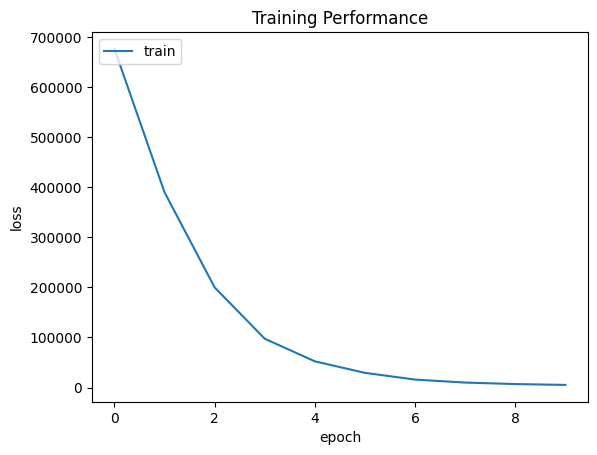

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['loss'])
plt.title('Training Performance')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
#Evaluation on validation set
seismic_model.SetTest(x, y)
y_hat = seismic_model.Predict()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-10-06 07:53:17.767125: W tensorflow/c/c_api.cc:305] Operation '{name:'decoder/dense_4/Sigmoid' id:248 op device:{requested: '', assigned: ''} def:{{{node decoder/dense_4/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder/dense_4/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [ ]:
y_loss = y - y_hat
print(np.argmax(y_loss[0]))
print(np.argmax(y[0]))
print(y[0][100:112])

86595
108
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
#Prediction
'''
Input: Model, test data
Output: pd.Dataframe or similar table with evaluation results
'''
#x_input=convert_to_batches_of_data(x_train,100)
seismic_model.SetTest(x_test[:,:429300])
y_hat = seismic_model.Predict()
# use argmax to find the timestamp with the value closest to 1
y_pred = np.argmax(y_hat, axis=1)
# construct a dataframe
df = dataTester.loadPredictions(y_pred)
# save as a csv file
df.to_csv('seismic-detections-'+seismic_model.name+'.csv')

In [ ]:
#Demo app
'''
Input: Model, sample input signal
'''